In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import netCDF4 as nc
import itertools
import cloud_generator_library as cl 

# Test example

In [2]:
cc = np.array([0.1, 0.2, 0.2, 0, 0.4, 0.3, 0, 0, 0.1, 0])[::-1]
lwc = np.array([0.05, 0.07, 0.01, 0, 0.1, 0.2, 0, 0, 0.04, 0])[::-1]
iwc = np.array([0.05, 0.07, 0.01, 0, 0.1, 0.2, 0, 0, 0.04, 0])[::-1]
H = np.array([1, 3, 7, 10, 14, 19, 25, 32, 40, 50])[::-1]

In [3]:
# Compute the correlation lengths of cloud cover and liquid water content
alpha = cl.correlation_param(H, 1.6)
lwc_corr = cl.correlation_param(H, 0.8)

Text(0, 0.5, 'z')

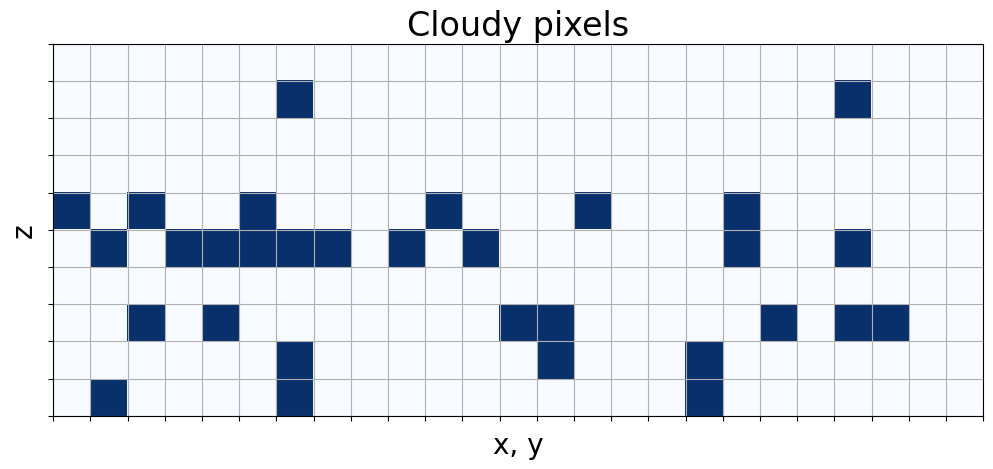

In [4]:
method = "max-ran"
f_zoom = 5

c_function, p_function = cl.get_cumulative_cc(method, cc, alpha)
cc_matrix, lwc_matrix, iwc_matrix = cl.fill_cloudy_layers(f_zoom, c_function, p_function, cc, lwc, iwc, lwc_corr)

fig, ax = plt.subplots(facecolor = 'w', figsize = (12,6))

ax.imshow(cc_matrix.T, cmap = 'Blues')

ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_yticks(np.arange(-0.5, len(cc)-0.4,1.0))
ax.set_xticks(np.arange(-0.5, f_zoom * f_zoom - 0.4))
ax.grid()
ax.set_title("Cloudy pixels", fontsize=24)
ax.set_xlabel("x, y", fontsize=20)
ax.set_ylabel("z", fontsize=20)


# Application to ERA5 reanalysis data

This is an example on how to convert the "ERA5 hourly data on pressure levels from 1940 to present" using the 3D CG. The dataset can be downloaded at the link: https://cds.climate.copernicus.eu/datasets/reanalysis-era5-pressure-levels?tab=overview

In [ ]:
method = 'exp-ran'
f_zoom = 3
 
# Replace with the name of the dataset downloaded from the ERA5 website
fname = "2023_01_15_T22.nc"

data = nc.Dataset(fname, "r", format='NETCDF4')

clwc_ERA5 = data.variables["clwc"][0]
ciwc_ERA5 = data.variables["ciwc"][0]
cc_ERA5 = data.variables["cc"][0]

# Define new latitude and longitude cell numbers
nlat_old = len(data.variables["latitude"])
nlon_old = len(data.variables["longitude"])
nlev = len(data.variables["level"])
nlat = nlat_old * f_zoom
nlon = nlon_old * f_zoom

# Create new dataset 
f = nc.Dataset("data_upscaled_x%d_%s.nc"%(f_zoom, method), "w", format='NETCDF4')

f.createDimension("longitude",len(data.dimensions["longitude"]) * f_zoom)
f.createDimension("latitude",len(data.dimensions["latitude"]) * f_zoom)
f.createDimension("level", len(data.dimensions["level"]))

longitude = f.createVariable("longitude", "f4", "longitude")
latitude = f.createVariable("latitude", "f4", "latitude")  
level = f.createVariable("level", "f4", "level")  

longitude[:] = np.arange(0, 360, 360 / nlon) 
latitude[:] = np.linspace(90,-90, nlat) 
level = data.variables["level"][:]

cc = f.createVariable("cc","f4",("latitude", "longitude", "level"))
ciwc = f.createVariable("ciwc","f4",("latitude", "longitude", "level"))
clwc = f.createVariable("clwc","f4",("latitude", "longitude", "level"))

z_level = np.loadtxt('ECMWF_37_levels.dat')[:,2] # ECMWF model levels in km

cos_lat = np.cos(np.radians(data.variables["latitude"][:]))

# Iterate over the whole globe
for i, j in itertools.product(range(int(nlat_old/4)), range(int(nlon_old/4))):
    # Compute decorrelation length once per latitude
    if j == 0:
        decorr_length = 0.75 + 2.149 * cos_lat[i]**2
        alpha = cl.correlation_param(z_level, decorr_length)
        lwc_corr = cl.correlation_param(z_level, 0.5 * decorr_length)
        print("%d / %d"%(i+1, nlat_old))

    # Perform calculations for each longitude
    c_function, p_function = cl.get_cumulative_cc(method, cc_ERA5[:, i, j], alpha)
    cc_matrix, lwc_matrix, iwc_matrix = cl.fill_cloudy_layers(
        f_zoom, c_function, p_function, cc_ERA5[:, i, j],
        clwc_ERA5[:, i, j], ciwc_ERA5[:, i, j], lwc_corr
    )

    # Assign results to output arrays
    cc[i*f_zoom:(i+1)*f_zoom, j*f_zoom:(j+1)*f_zoom] = np.reshape(cc_matrix, (f_zoom, f_zoom, nlev))
    clwc[i*f_zoom:(i+1)*f_zoom, j*f_zoom:(j+1)*f_zoom] = np.reshape(lwc_matrix, (f_zoom, f_zoom, nlev))
    ciwc[i*f_zoom:(i+1)*f_zoom, j*f_zoom:(j+1)*f_zoom] = np.reshape(iwc_matrix, (f_zoom, f_zoom, nlev))

f.close()